# Problem Statement

To build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

Key questions to be answered:

1. Which variables are significant in predicting the price of a house, and

2. How well those variables describe the price of a house.


Since we will be building a regularized model we should determine the optimal value of lambda for ridge and lasso regression as well.

The model will be used by the management to understand how exactly the prices vary with the variables which will help them manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model should be a good way for management to understand the pricing dynamics of a new market.

# Data Loading
## Step 1: Reading & Analsying the data

In [520]:
# importing the requisite libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [521]:
# Importing data set
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [522]:
# Removing Duplicate Data if any
df.drop_duplicates(keep='first', inplace=True)
df.drop(columns=['Id'], inplace=True)
df.shape

(1460, 80)

In [523]:
curr_year = datetime.date.today().year

df['property_age'] = curr_year - df['YearBuilt']
df['years_since_remodel'] = curr_year - df['YearRemodAdd']
df['garage_age'] = curr_year - df['GarageYrBlt']

df.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], inplace=True)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,property_age,years_since_remodel,garage_age
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,2,2008,WD,Normal,208500,20,20,20.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,0,5,2007,WD,Normal,181500,47,47,47.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,0,9,2008,WD,Normal,223500,22,21,22.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,0,2,2006,WD,Abnorml,140000,108,53,25.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,0,12,2008,WD,Normal,250000,23,23,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,8,2007,WD,Normal,175000,24,23,24.0
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,2,2010,WD,Normal,210000,45,35,45.0
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,Shed,2500,5,2010,WD,Normal,266500,82,17,82.0
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,4,2010,WD,Normal,142125,73,27,73.0


In [524]:
#Creating a function to create a df showing the % of missing data for each column
def create_missing_df(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_df = pd.DataFrame({'col_name': df.columns,'percent_missing': percent_missing})
    missing_df[missing_df['percent_missing'] != 0]
    return missing_df[missing_df['percent_missing'] > 0]

In [525]:
# Analysing the data to choose the best approach to clean missing data
create_missing_df(df).sort_values('percent_missing', ascending=False)

,col_name,percent_missing
PoolQC,PoolQC,99.520548
MiscFeature,MiscFeature,96.301370
Alley,Alley,93.767123
Fence,Fence,80.753425
FireplaceQu,FireplaceQu,47.260274
LotFrontage,LotFrontage,17.739726
GarageCond,GarageCond,5.547945
GarageQual,GarageQual,5.547945
GarageFinish,GarageFinish,5.547945
GarageType,GarageType,5.547945


The top 5 columns with the most missing values are technically not missing values but one of their unqiue values happens to be 'NA' meaning that quality/feature of the house does not exist. So let us convert those NAs to a more appropriate value for each of those 5 columns.

In [526]:
# Converting NA to a more appropriate value
df['Alley'].fillna("No Access", inplace=True)
df['MasVnrType'].fillna("No Masonry", inplace=True)
df['BsmtQual'].fillna("No Basement", inplace=True)
df['BsmtCond'].fillna("No Basement", inplace=True)
df['BsmtExposure'].fillna("No Basement", inplace=True)
df['BsmtFinType1'].fillna("No Basement", inplace=True)
df['BsmtFinType2'].fillna("No Basement", inplace=True)
df['FireplaceQu'].fillna("No Fireplace", inplace=True)
df['GarageType'].fillna("No Garage", inplace=True)
df['GarageFinish'].fillna("No Garage", inplace=True)
df['GarageQual'].fillna("No Garage", inplace=True)
df['GarageCond'].fillna("No Garage", inplace=True)
df['PoolQC'].fillna("No Pool", inplace=True)
df['Fence'].fillna("No Fence", inplace=True)
df['MiscFeature'].fillna("No MiscFeature", inplace=True)

In [527]:
# Recreating the missing df now to check for other approaches we shall take
create_missing_df(df)

,col_name,percent_missing
LotFrontage,LotFrontage,17.739726
MasVnrArea,MasVnrArea,0.547945
Electrical,Electrical,0.068493
garage_age,garage_age,5.547945


<AxesSubplot:>

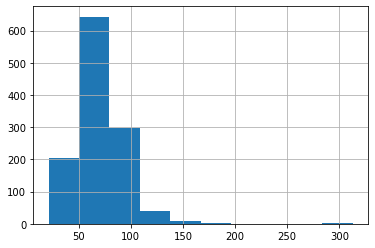

In [528]:
# Checking to see if LotFrontage is normally distributed for missing value imputation.
df['LotFrontage'].hist()

Since the distribution of LotFrontage is sort of normal and the definition of lot frontages is "Linear feet of street connected to property" we can impute the missing values with the mean value of every neighbourhood

In [529]:
df['LotFrontage'] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))
df['LotFrontage'].describe()

count    1460.000000
mean       70.725218
std        22.426978
min        21.000000
25%        60.000000
50%        70.083333
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

<AxesSubplot:>

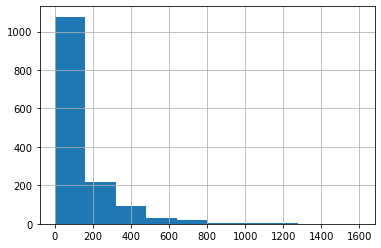

In [530]:
df['MasVnrArea'].hist()

<AxesSubplot:>

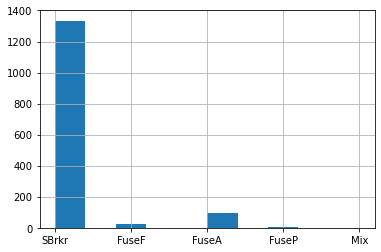

In [531]:
df['Electrical'].hist()

<AxesSubplot:>

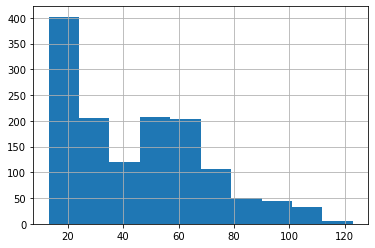

In [532]:
df['garage_age'].hist()

As seena above, the 3 variables are not normally distributed and therefore any imputation of missing values would not be appropriate and also they contribute only a small number of rows in our data

In [533]:
create_missing_df(df).sort_values('percent_missing', ascending=False)

,col_name,percent_missing
garage_age,garage_age,5.547945
MasVnrArea,MasVnrArea,0.547945
Electrical,Electrical,0.068493


In [534]:
# df.dropna(inplace=True)
df = df.dropna(subset=['Electrical', 'MasVnrArea'])
df["garage_age"].fillna(df["garage_age"].median(), inplace=True)

In [535]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MSSubClass           1451 non-null   int64  
 1   MSZoning             1451 non-null   object 
 2   LotFrontage          1451 non-null   float64
 3   LotArea              1451 non-null   int64  
 4   Street               1451 non-null   object 
 5   Alley                1451 non-null   object 
 6   LotShape             1451 non-null   object 
 7   LandContour          1451 non-null   object 
 8   Utilities            1451 non-null   object 
 9   LotConfig            1451 non-null   object 
 10  LandSlope            1451 non-null   object 
 11  Neighborhood         1451 non-null   object 
 12  Condition1           1451 non-null   object 
 13  Condition2           1451 non-null   object 
 14  BldgType             1451 non-null   object 
 15  HouseStyle           1451 non-null   o

In [536]:
create_missing_df(df).sort_values('percent_missing', ascending=False)

,col_name,percent_missing


We have now handled all missing data in our dataset.

## Target Variable Distribution

<AxesSubplot:>

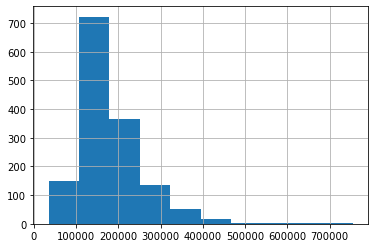

In [537]:
df['SalePrice'].hist()

Since our target variable is skewed as well, let us transform this using a log scale to see how the newly transformed target variable looks like

<AxesSubplot:>

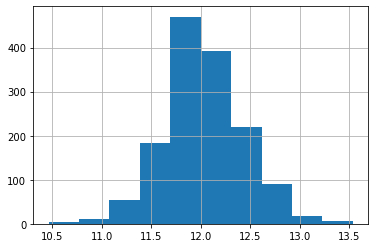

In [538]:
df['SalePrice'] = np.log1p(df['SalePrice'])
df['SalePrice'].hist()

Now we can proceed to the next step since our target variable is normally distributed.

### Let us group all of the categorical features to do some feature engineering. Since some of the column's unique values overlap with each other, let us add the column name as a prefix to its own value so it will be easier to identify them once we create dummy variables.

# Data Analysis

In [539]:
# Separating numerical features from the rest
num_df = df.loc[:, ~df.columns.isin(list(cat_df.columns))]
num_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,property_age,years_since_remodel,garage_age
0,60,65.0,8450,7,5,196.0,706,0,150,856,...,0,0,0,0,2,2008,12.247699,20,20,20.0
1,20,80.0,9600,6,8,0.0,978,0,284,1262,...,0,0,0,0,5,2007,12.109016,47,47,47.0
2,60,68.0,11250,7,5,162.0,486,0,434,920,...,0,0,0,0,9,2008,12.317171,22,21,22.0
3,70,60.0,9550,7,5,0.0,216,0,540,756,...,0,0,0,0,2,2006,11.849405,108,53,25.0
4,60,84.0,14260,8,5,350.0,655,0,490,1145,...,0,0,0,0,12,2008,12.429220,23,23,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,0.0,0,0,953,953,...,0,0,0,0,8,2007,12.072547,24,23,24.0
1456,20,85.0,13175,6,6,119.0,790,163,589,1542,...,0,0,0,0,2,2010,12.254868,45,35,45.0
1457,70,66.0,9042,7,9,0.0,275,0,877,1152,...,0,0,0,2500,5,2010,12.493133,82,17,82.0
1458,20,68.0,9717,5,6,0.0,49,1029,0,1078,...,0,0,0,0,4,2010,11.864469,73,27,73.0


In [540]:
# Adding column names to it's values as a prefix identifier
def add_column_name_to_val(column):
    cat_df[column] = str(column) + '_' + cat_df[column]

for each in cat_df.columns:
    add_column_name_to_val(each)
    
cat_df

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_CollgCr,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
1,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_FR2,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_Veenker,Condition1_Condition1_Feedr,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
2,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_IR1,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_CollgCr,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
3,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_IR1,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Corner,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_Crawfor,Condition1_Condition1_Norm,...,GarageType_GarageType_Detchd,GarageFinish_GarageFinish_Unf,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Abnorml
4,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_IR1,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_FR2,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_NoRidge,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_Gilbert,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
1456,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_NWAmes,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_Unf,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_MnPrv,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
1457,MSZoni

## Boxplot Analysis

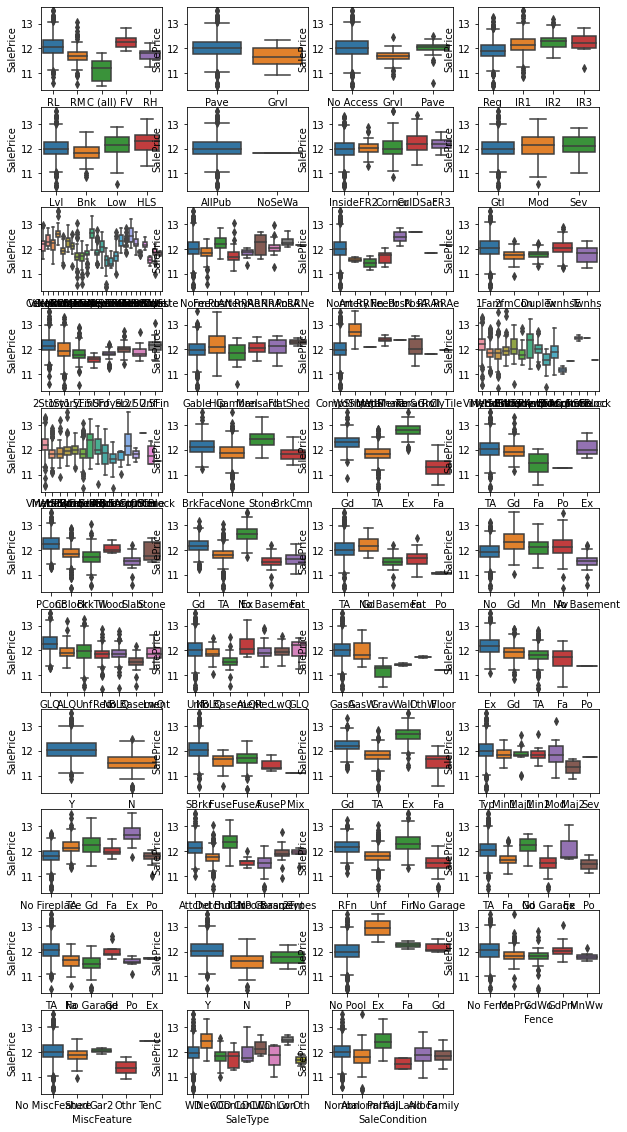

In [541]:
plt.figure(figsize=(10, 20))
i = 1
for each in cat_df.columns:
    plt.subplot(11, 4, i)
    sns.boxplot(x = each, y = 'SalePrice', data = df)
    i += 1
plt.show()

In [542]:
cat_df = cat_df.select_dtypes(include='object')
cat_df

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_CollgCr,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
1,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_FR2,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_Veenker,Condition1_Condition1_Feedr,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
2,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_IR1,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_CollgCr,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
3,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_IR1,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Corner,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_Crawfor,Condition1_Condition1_Norm,...,GarageType_GarageType_Detchd,GarageFinish_GarageFinish_Unf,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Abnorml
4,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_IR1,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_FR2,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_NoRidge,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_Gilbert,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_RFn,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_No Fence,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
1456,MSZoning_MSZoning_RL,Street_Street_Pave,Alley_Alley_No Access,LotShape_LotShape_Reg,LandContour_LandContour_Lvl,Utilities_Utilities_AllPub,LotConfig_LotConfig_Inside,LandSlope_LandSlope_Gtl,Neighborhood_Neighborhood_NWAmes,Condition1_Condition1_Norm,...,GarageType_GarageType_Attchd,GarageFinish_GarageFinish_Unf,GarageQual_GarageQual_TA,GarageCond_GarageCond_TA,PavedDrive_PavedDrive_Y,PoolQC_PoolQC_No Pool,Fence_Fence_MnPrv,MiscFeature_MiscFeature_No MiscFeature,SaleType_SaleType_WD,SaleCondition_SaleCondition_Normal
1457,MSZoni

## Pairplot Analysis

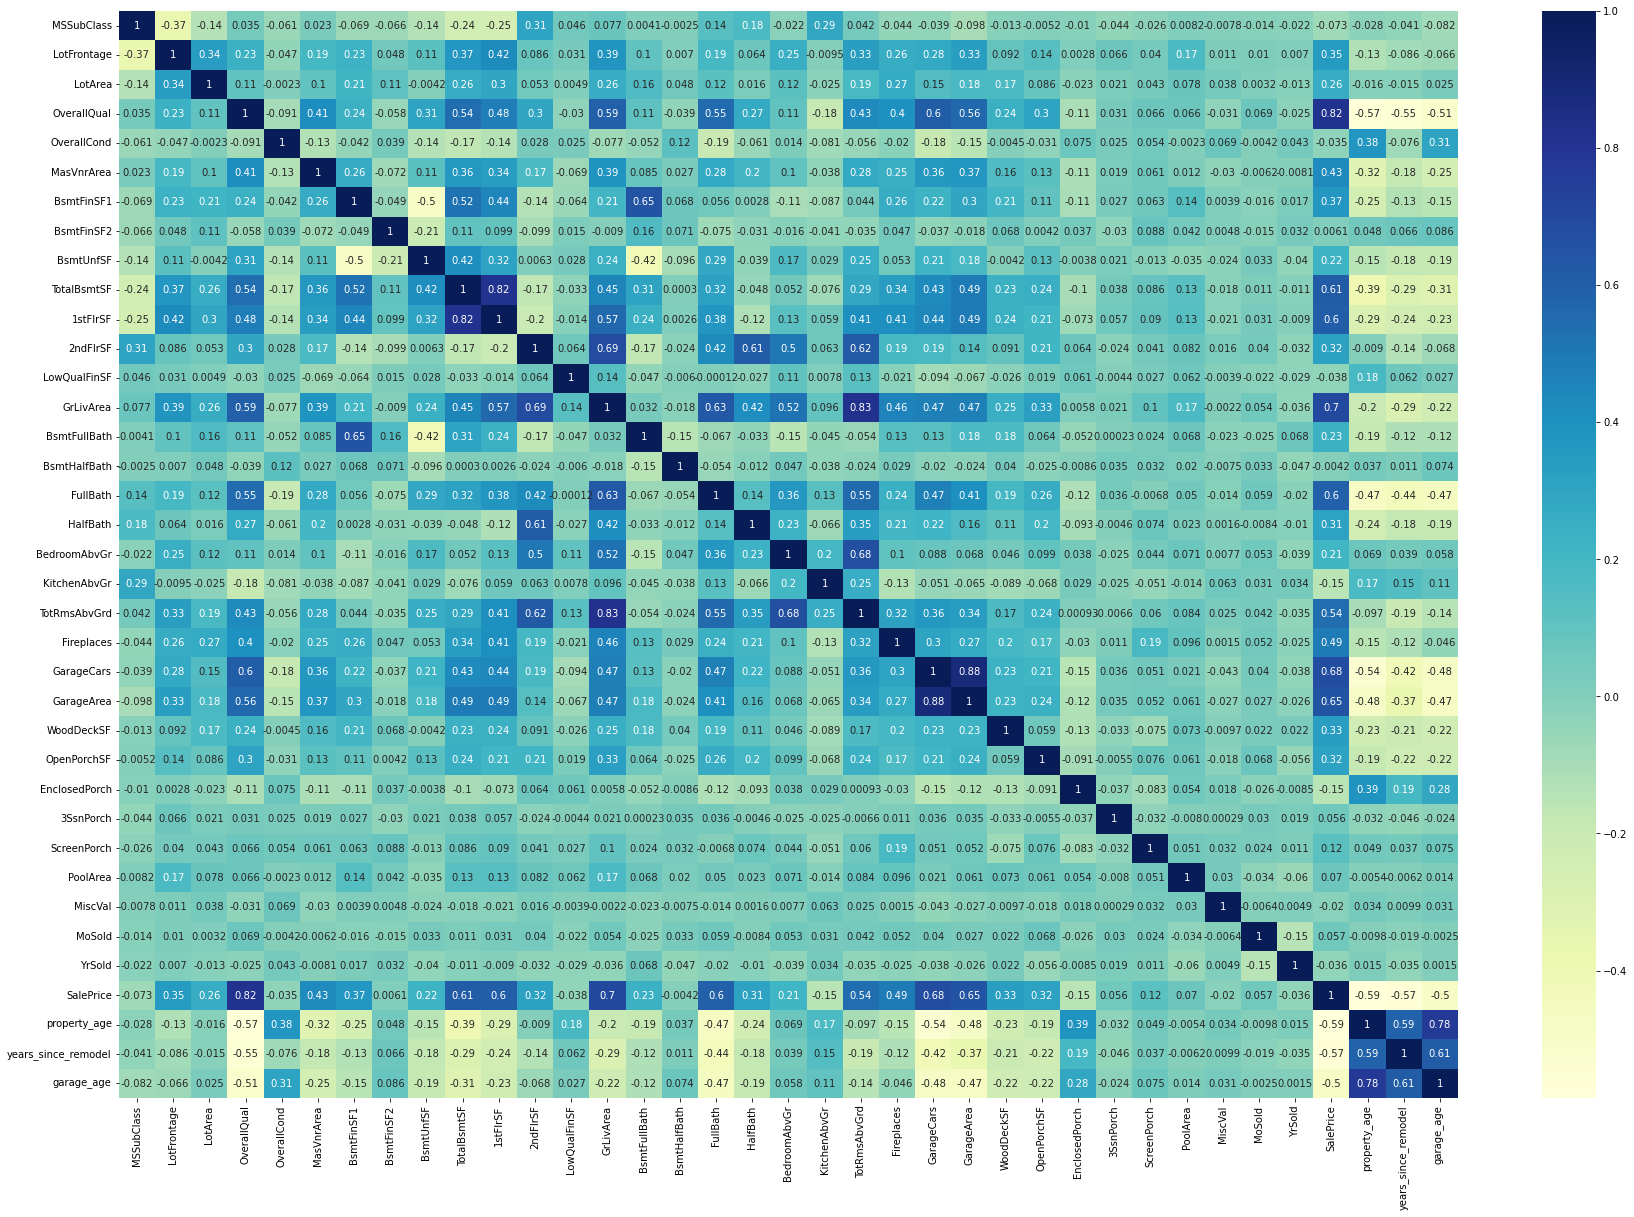

In [543]:
df_cor = num_df.corr()

plt.figure(figsize=(30,20))

# heatmap
sns.heatmap(df_cor, cmap="YlGnBu", annot=True)
plt.show()

We can see that a lot of variable have high colinearity between them but since we will be deploying ridge and lasso regression models, these variables effect on the model will invariably be extremely shrunk or removed altogether. Therefore we do not need to remove them manually for now.

# Data Preparation
## Dummy Variables

In [544]:
# Creating dummy vaariables for any categorical variables that have non numerical & > 2 unique values
housing_df = num_df 

list_of_dummies = []
for each in cat_df.columns:
    housing_df = pd.concat([housing_df, pd.get_dummies(cat_df[each], drop_first=True)], axis=1)

housing_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_SaleType_ConLI,SaleType_SaleType_ConLw,SaleType_SaleType_New,SaleType_SaleType_Oth,SaleType_SaleType_WD,SaleCondition_SaleCondition_AdjLand,SaleCondition_SaleCondition_Alloca,SaleCondition_SaleCondition_Family,SaleCondition_SaleCondition_Normal,SaleCondition_SaleCondition_Partial
0,60,65.0,8450,7,5,196.0,706,0,150,856,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,0.0,978,0,284,1262,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,162.0,486,0,434,920,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,0.0,216,0,540,756,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,350.0,655,0,490,1145,...,0,0,0,0,1,0,0,0,1,0


Now we have 261 columns to work with in our regression model after creating dummy variables.

# Test/Train Split

In [545]:
np.random.seed(0)
df_train, df_test = train_test_split(housing_df, train_size = 0.7, test_size = 0.3, random_state = 100)

# Scaling
Since we will be using regularization we need to scale our input features and the categorical values already only range only between 0 and 1.

In [546]:
scaler = StandardScaler()

num_vars = list(num_df.columns)

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

df_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_SaleType_ConLI,SaleType_SaleType_ConLw,SaleType_SaleType_New,SaleType_SaleType_Oth,SaleType_SaleType_WD,SaleCondition_SaleCondition_AdjLand,SaleCondition_SaleCondition_Alloca,SaleCondition_SaleCondition_Family,SaleCondition_SaleCondition_Normal,SaleCondition_SaleCondition_Partial
801,-0.650652,-1.310582,-0.513865,-1.552452,1.293141,-0.562965,-0.502945,-0.297804,0.936307,0.294756,...,0,0,0,0,1,0,0,0,1,0
569,0.788676,0.240262,-0.315476,-0.824292,-0.538734,-0.562965,1.097605,-0.297804,-1.320626,-0.273317,...,0,0,0,0,1,0,0,0,1,0
1181,1.508340,-0.289797,-0.443913,1.360189,-0.538734,0.447197,2.249743,-0.297804,-1.049523,1.201876,...,0,0,1,0,0,0,0,0,0,1
808,0.548788,0.603390,0.250537,-0.824292,-0.538734,5.123271,0.181472,0.484095,-0.462133,-0.091444,...,0,0,0,0,1,0,0,0,1,0
1095,-0.890540,0.305661,-0.112376,-0.096131,-0.538734,-0.562965,-0.874119,-0.297804,1.593732,0.559707,...,0,0,0,0,1,0,0,0,1,0


In [547]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_SaleType_ConLI,SaleType_SaleType_ConLw,SaleType_SaleType_New,SaleType_SaleType_Oth,SaleType_SaleType_WD,SaleCondition_SaleCondition_AdjLand,SaleCondition_SaleCondition_Alloca,SaleCondition_SaleCondition_Family,SaleCondition_SaleCondition_Normal,SaleCondition_SaleCondition_Partial
count,1.015000e+03,1.015000e+03,1.015000e+03,1.015000e+03,1.015000e+03,1.015000e+03,1.015000e+03,1.015000e+03,1.015000e+03,1.015000e+03,...,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,-1.020530e-16,6.578755e-16,4.525663e-17,-2.582362e-16,2.666723e-16,8.512621e-17,1.045688e-16,9.363063e-17,1.225894e-16,7.219184e-18,...,0.002956,0.002956,0.081773,0.001970,0.867980,0.003941,0.008867,0.008867,0.826601,0.083744
std,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,...,0.054312,0.054312,0.274154,0.044368,0.338679,0.062684,0.093793,0.093793,0.378778,0.277140
min,-8.905396e-01,-2.118703e+00,-8.249587e-01,-3.008772e+00,-3.286546e+00,-5.629652e-01,-9.256108e-01,-2.978043e-01,-1.320626e+00,-2.390681e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.905396e-01,-4.599275e-01,-2.738784e-01,-8.242917e-01,-5.387336e-01,-5.629652e-01,-9.256108e-01,-2.978043e-01,-7.637350e-01,-5.955249e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.708758e-01,-3.105598e-02,-1.065989e-01,-9.613150e-02,-5.387336e-01,-5.629652e-01,-1.768280e-01,-2.978043e-01,-1.774746e-01,-1.722768e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.089000e-01,3.907267e-01,8.281275e-02,6.320287e-01,3.772038e-01,3.548704e-01,5.751730e-01,-2.978043e-01,5.590222e-01,5.249037e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,3.187555e+00,1.030085e+01,1.819131e+01,2.816509e+00,3.125016e+00,8.126603e+00,1.118364e+01,6.543816e+00,3.956848e+00,1.132840e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Prepping Data for Model
Let us now split our target variable from the independant variables

In [548]:
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

# Add a constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test, has_constant='add')

# Simple Miltiple Linear Regression
## Model 1

In [549]:
# Create a first fitted model
lr = sm.OLS(y_train, X_train).fit()

print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     73.29
Date:                Tue, 26 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:57:19   Log-Likelihood:                 172.08
No. Observations:                1015   AIC:                             141.8
Df Residuals:                     772   BIC:                             1338.
Df Model:                         242                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [550]:
y_pred = lr.predict(X_train)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print(r2, mse)

0.9582872961942118 0.041712703805788176


The R2 value seems to be really good at 95.8% indicating a simple linear regression model is able to explain 95.8% of the variance in the data. But let us see how well a simply linear regression model does on unseen data

In [551]:
y_test_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(r2, mse)

0.6984150232270399 0.3015849767729602


# As seen above, it is very evident that there is high overfitting as the r2 on the test set has dropped from 95.8%

We can make sure the underlying assumptions for linear regression hold good through residual plot analysis and the distribution of errors before we move on to Ridge and Lasso.

# Residual Plot Analysis

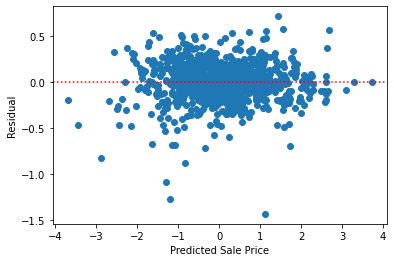

In [552]:
residual = y_train - y_pred
# Scatter plot of the predicted values on the x-axis and the residuals on the y-axis
plt.scatter( y_pred , residual)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residual")
plt.show()

# Distribution of Errors

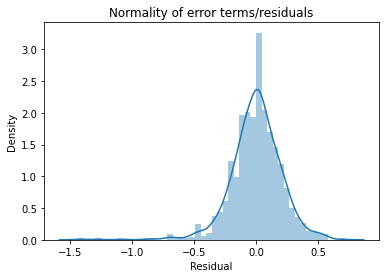

In [553]:
# Distribution of errors
p = sns.distplot(residual,kde=True)
p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residual")
plt.show()

### Both the residual plot and distribution of errors looks good enough to indicate that the underlying assumptions for linear regression holds good.

### Now let us try a regularized version to add some penalization on features

# Ridge Regression
## Models 2 - 14

In [554]:
# Applying ridge regression using 12 different lambdas and comparing performances
ridge_comparison_df = pd.DataFrame()
ridge_comparison_df

ridge_lambdas = [0.01, 0.1, 1, 2, 4, 8, 15, 30, 50, 100, 500, 1000]

tmp_d = {}

for lam in ridge_lambdas:
    ridge_reg = Ridge(alpha = lam)
    ridge_reg.fit(X_train, y_train)
    y_pred = ridge_reg.predict(X_train)

    tmp_d['lambda'] = lam
    tmp_d['train_R2'] = r2_score(y_train, y_pred)*100 
    
    y_test_pred = ridge_reg.predict(X_test)
    tmp_d['test_R2'] = r2_score(y_test, y_test_pred)*100 
    
    ridge_comparison_df = ridge_comparison_df.append(tmp_d, ignore_index=True)

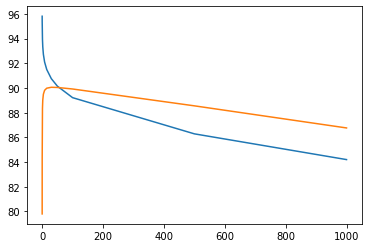

In [555]:
# Plotting the train vs test R2 scores to find the optimum lambda
plt.plot(ridge_comparison_df['lambda'], ridge_comparison_df['train_R2'])    
plt.plot(ridge_comparison_df['lambda'], ridge_comparison_df['test_R2'])  # Plot the chart
plt.show()

In [556]:
ridge_comparison_df['Absolute diff b/w train and test'] = abs(ridge_comparison_df['train_R2'] - ridge_comparison_df['test_R2'])
ridge_comparison_df.sort_values('Absolute diff b/w train and test')

,lambda,train_R2,test_R2,Absolute diff b/w train and test
8,50.00,90.146843,90.042053,0.104791
7,30.00,90.757360,90.056666,0.700694
9,100.00,89.216061,89.917490,0.701429
6,15.00,91.496709,89.981783,1.514927
10,500.00,86.286887,88.554482,2.267596
5,8.00,92.100527,89.811332,2.289195
11,1000.00,84.202146,86.764483,2.562336
4,4.00,92.726016,89.495788,3.230228
3,2.00,93.336721,89.028087,4.308634
2,1.00,93.932518,88.351709,5.580809


Since a lambda of 50 is able to achieve a r2 score of 90% even on the test set without much difference from the train score and as seen above in the graph it also where the R2 score smoothes out, so let us choose that to be our final lambda value for our ridge regression model.

# Lasso Regression
## Models 14 - 27

In [576]:
lass_comparison_df = pd.DataFrame()
lass_comparison_df

lass_lambdas = [0.0001, 0.001, 0.01, 0.02, 0.1, 1, 2, 5, 10, 20, 50, 100, 500, 1000]

r2s = []
tmp_d = {}
for lam in lass_lambdas:
    lasso_reg = Lasso(alpha = lam)
    lasso_reg.fit(X_train, y_train)    
    y_pred = lasso_reg.predict(X_train)
    tmp_d['lambda'] = lam
    tmp_d['train_R2'] = r2_score(y_train, y_pred)*100
    tmp_d['# Features Selected After Lasso'] = pd.Series(lasso_reg.coef_).where(abs(pd.Series(lasso_reg.coef_)) > 0.001 ).count()   
#     r2s.append(r2_score(y_train, y_pred))

    y_test_pred = lasso_reg.predict(X_test)
    tmp_d['test_R2'] = r2_score(y_test, y_test_pred)*100
    

    lass_comparison_df = lass_comparison_df.append(tmp_d, ignore_index=True) 

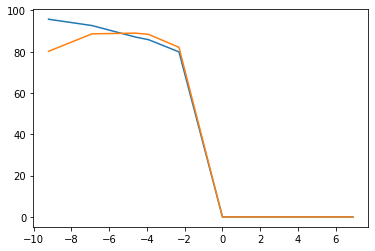

In [577]:
# Plotting the train vs test R2 scores to find the optimum lambda
plt.plot(np.log(lass_comparison_df['lambda']), lass_comparison_df['train_R2'])    
plt.plot(np.log(lass_comparison_df['lambda']), lass_comparison_df['test_R2'])  # Plot the chart
# plt.xlim(-10, 50)
plt.show()   

In [578]:
lass_comparison_df['Absolute diff b/w train and test'] = abs(lass_comparison_df['train_R2'] - lass_comparison_df['test_R2'])
lass_comparison_df[lass_comparison_df['train_R2'] > 0].sort_values('Absolute diff b/w train and test')

,lambda,train_R2,# Features Selected After Lasso,test_R2,Absolute diff b/w train and test
2,0.0100,87.046451,38.0,88.948473,1.902022
4,0.1000,79.863298,10.0,82.086682,2.223385
3,0.0200,85.771142,27.0,88.348534,2.577392
1,0.0010,92.611153,132.0,88.603142,4.008011
0,0.0001,95.669996,210.0,80.148033,15.521963


Since a lambda of 0.01 is able to achieve a r2 score of almost 90% even on the test set without much difference from the train score and as seen above in the graph it also where the R2 score smoothes out, so let us choose that to be our final lambda value for our lasso regression model.

# The Chosen Models

In [589]:
# Ridge Model
ridge_reg = Ridge(alpha = 50)
ridge_reg.fit(X_train, y_train)

Ridge(alpha=50)

In [590]:
# Lasso Model
lasso_reg = Lasso(alpha = 0.01)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.01)

In [591]:
betas = pd.DataFrame(index=X_train.columns, columns=['Ridge', 'Lasso'])
betas['Ridge'] = ridge_reg.coef_
betas['Lasso'] = lasso_reg.coef_
betas

,Ridge,Lasso
const,0.000000,0.000000
MSSubClass,-0.048170,-0.044906
LotFrontage,-0.020041,-0.000000
LotArea,0.044717,0.041490
OverallQual,0.222885,0.305616
...,...,...
SaleCondition_SaleCondition_AdjLand,0.007062,0.000000
SaleCondition_SaleCondition_Alloca,0.005458,-0.000000
SaleCondition_SaleCondition_Family,0.025337,0.000000
SaleCondition_SaleCondition_Normal,0.093483,0.000000


In [600]:
betas['Ridge'].sort_values(key=abs, ascending=False)

OverallQual                          0.222885
GrLivArea                            0.127915
OverallCond                          0.119832
GarageCars                           0.116810
Neighborhood_Neighborhood_NridgHt    0.113683
                                       ...   
Exterior1st_Exterior1st_AsphShn      0.000000
Condition2_Condition2_RRNn           0.000000
ExterCond_ExterCond_Po               0.000000
Condition2_Condition2_RRAe           0.000000
const                                0.000000
Name: Ridge, Length: 260, dtype: float64

In [616]:
lasso_op = betas.sort_values(by='Lasso', key=abs, ascending=False)['Lasso']
lasso_op.head(10)

OverallQual                      0.305616
GrLivArea                        0.241827
GarageCars                       0.155088
property_age                    -0.144264
OverallCond                      0.121011
MSZoning_MSZoning_RM            -0.100980
Condition1_Condition1_Norm       0.100386
BsmtFullBath                     0.073977
BsmtFinType1_BsmtFinType1_Unf   -0.058848
Fireplaces                       0.056689
Name: Lasso, dtype: float64

In [614]:
pd.Series(lasso_reg.coef_).where(abs(pd.Series(lasso_reg.coef_)) > 0)


0           NaN
1     -0.044906
2           NaN
3      0.041490
4      0.305616
         ...   
255         NaN
256         NaN
257         NaN
258         NaN
259         NaN
Length: 260, dtype: float64

## Though the Ridge model's R2 score is higher than Lasso model we will suggest the Lasso model since it eliminates more than 70% of the variables and thereby creating a simple model. As per Occam's Razor we always go with the simpler model. Above are all the variables the company should focus on when it comes to investing in properties.

### The top 5 variables are (according to Lasso, @ 0.01)
1. Overall Quality
2. Above ground living area square feet
3. Size of garage in car capacity
4. Property Age
5. Overall Condition

### In the top 5 variables, apart from the property age, all other 4 are postively influencing the selling price, i.e., any increase in these variables increases the selling price where as older the house, lesser the price.

# Part 2 Question's Reference Code

In [617]:
X_train.drop(columns=['OverallQual', 'GrLivArea', 'GarageCars', 'property_age' , 'OverallCond'], inplace=True)
X_test.drop(columns=['OverallQual', 'GrLivArea', 'GarageCars', 'property_age' , 'OverallCond'], inplace=True)

In [622]:
lasso_reg.fit(X_train, y_train)
lasso_op = pd.DataFrame(index=X_train.columns, columns=['Coefficients'])
lasso_op['Coefficients'] = lasso_reg.coef_
lasso_op.sort_values(by='Coefficients', key=abs, ascending=False)

,Coefficients
1stFlrSF,0.198053
CentralAir_CentralAir_Y,0.191198
2ndFlrSF,0.184072
GarageArea,0.149183
years_since_remodel,-0.133841
...,...
RoofMatl_RoofMatl_Metal,0.000000
RoofMatl_RoofMatl_Roll,0.000000
RoofMatl_RoofMatl_Tar&Grv,-0.000000
RoofMatl_RoofMatl_WdShake,0.000000
